# LFW Clustering with RetinaFace + ArcFace

## 0. Setup

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import cv2
from insightface.app import FaceAnalysis
from tqdm import tqdm
import pandas as pd

## 1. Load LFW dataset

In [8]:
lfw = fetch_lfw_people(min_faces_per_person=10, resize=0.5) #min_faces_per_person=10 to ensure enough samples per identity, resize=0.5 to reduce image size for faster processing
images = lfw.images
labels = lfw.target
label_names = lfw.target_names
print(f"Images shape: {images.shape}, Identities: {len(np.unique(labels))}")

Images shape: (4324, 62, 47), Identities: 158


## 2. Initialize Face Detection + Embeddings

In [9]:
app = FaceAnalysis(name="buffalo_l")  #arcface
app.prepare(ctx_id=0, det_size=(160,160))  #app.prepare initializes the model for face detection and embedding extraction

def detect_and_embed(img):
    img_uint8 = (img * 255).astype(np.uint8) #convert image to uint8
    if len(img_uint8.shape) == 2: #if grayscale image
        img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR) #convert to BGR
    else:
        img_bgr = img_uint8 #image is already 3-channel
    faces = app.get(img_bgr)  #app.get performs face detection
    if len(faces) == 0: #no faces detected
        return None
    return faces[0].embedding #return the embedding of the first detected face

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:02<00:00, 94786.45KB/s]
/usr/local/lib/python3.12/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (160, 160)


## 3. Extract embeddings

In [10]:
embeddings = []
valid_labels = []
for img, lbl in tqdm(zip(images, labels), total=len(images), desc="Processing images"): #for each image and label
    emb = detect_and_embed(img) #detect face and extract embedding
    if emb is not None: #if embedding is valid, store emb & label
        embeddings.append(emb)
        valid_labels.append(lbl)

embeddings = np.stack(embeddings)
valid_labels = np.array(valid_labels)
print(f"Extracted embeddings shape: {embeddings.shape}")

Processing images: 100%|██████████| 4324/4324 [43:19<00:00,  1.66it/s]

Extracted embeddings shape: (4324, 512)


In [11]:
#save data to csv
embeddings_df = pd.DataFrame(embeddings)
embeddings_df['label'] = valid_labels
embeddings_df.to_csv('lfw_face_embeddings.csv', index=False)
print("Embeddings and valid_labels saved to 'lfw_face_embeddings.csv'")

Embeddings and valid_labels saved to 'lfw_face_embeddings.csv'


## 4. Cluster by identity

In [12]:
identity_clusters = {lbl: embeddings[valid_labels==lbl] for lbl in np.unique(valid_labels)}

In [13]:
cluster_stats = {}
for lbl, cluster in identity_clusters.items():
    centroid = cluster.mean(axis=0)
    distances = np.linalg.norm(cluster - centroid, axis=1)
    cluster_stats[label_names[lbl]] = {
        "centroid": centroid,
        "radius": distances.max(),
        "dispersion": distances.std(),
        "num_images": len(cluster)
    }

In [14]:
print(cluster_stats)

{np.str_('Abdullah Gul'): {'centroid': array([-0.73390454, -1.2285999 ,  1.1693896 ,  0.07521358, -0.22906244,
        0.6754177 , -1.2414875 , -1.335612  ,  0.83845514, -0.8637751 ,
       -1.6851219 , -0.4739934 , -1.2903242 , -2.0947616 ,  1.0509217 ,
       -1.4389912 , -0.82211083,  0.3557731 ,  0.6576315 ,  0.02684408,
        0.55242294,  1.1603924 , -1.2267302 ,  2.1294146 , -1.226348  ,
        0.35816053,  1.0238037 ,  1.8849638 ,  1.316754  , -0.6498495 ,
        0.16744345, -0.80615807,  0.5168713 ,  0.2688766 ,  0.2129507 ,
        0.6474511 , -0.6762704 , -0.20609282,  0.28439116, -0.44382954,
        1.0101964 , -0.25477502,  0.10561495,  0.6434485 ,  0.6707619 ,
        0.1415027 ,  0.76547366,  1.2897869 ,  1.1700116 , -0.60551673,
       -0.8726792 ,  0.6045198 , -0.7093701 ,  0.05483013, -1.8979279 ,
       -0.42701626,  0.9414206 , -0.11216936,  0.18622567,  0.47953853,
       -1.7059203 ,  0.46189448, -0.34218207,  0.60242903, -0.22417748,
       -0.34310216,  0.32

## 5. Intrinsic dimensionality

In [15]:
intrinsic_dim = {}
for lbl, cluster in identity_clusters.items():
    if len(cluster) < 2: #do nothing
        continue
    pca = PCA(n_components=min(len(cluster), cluster.shape[1])) #min(len cluster and 512D)
    pca.fit(cluster)
    intrinsic_dim[label_names[lbl]] = np.sum(pca.explained_variance_ratio_ > 0.01)

- pca.explanined_variance_ratio_: vector size min(n,D) contains the fraction of variance explained for each principal component.
- .>0.01: PC explains more than 1%
- sum the ones that are >0.01, and those are the intrinsic dimension

In [16]:
#intrinsic dimensions by identity
for identity, dim in intrinsic_dim.items():
    print(f"Identity: {identity}, Intrinsic Dimension: {dim}")

Identity: Abdullah Gul, Intrinsic Dimension: 17
Identity: Adrien Brody, Intrinsic Dimension: 11
Identity: Alejandro Toledo, Intrinsic Dimension: 29
Identity: Alvaro Uribe, Intrinsic Dimension: 29
Identity: Amelie Mauresmo, Intrinsic Dimension: 20
Identity: Andre Agassi, Intrinsic Dimension: 30
Identity: Andy Roddick, Intrinsic Dimension: 14
Identity: Angelina Jolie, Intrinsic Dimension: 19
Identity: Ann Veneman, Intrinsic Dimension: 10
Identity: Anna Kournikova, Intrinsic Dimension: 11
Identity: Ari Fleischer, Intrinsic Dimension: 11
Identity: Ariel Sharon, Intrinsic Dimension: 30
Identity: Arnold Schwarzenegger, Intrinsic Dimension: 31
Identity: Atal Bihari Vajpayee, Intrinsic Dimension: 23
Identity: Bill Clinton, Intrinsic Dimension: 27
Identity: Bill Gates, Intrinsic Dimension: 16
Identity: Bill McBride, Intrinsic Dimension: 9
Identity: Bill Simon, Intrinsic Dimension: 14
Identity: Britney Spears, Intrinsic Dimension: 13
Identity: Carlos Menem, Intrinsic Dimension: 20
Identity: Carl

Plot with initials

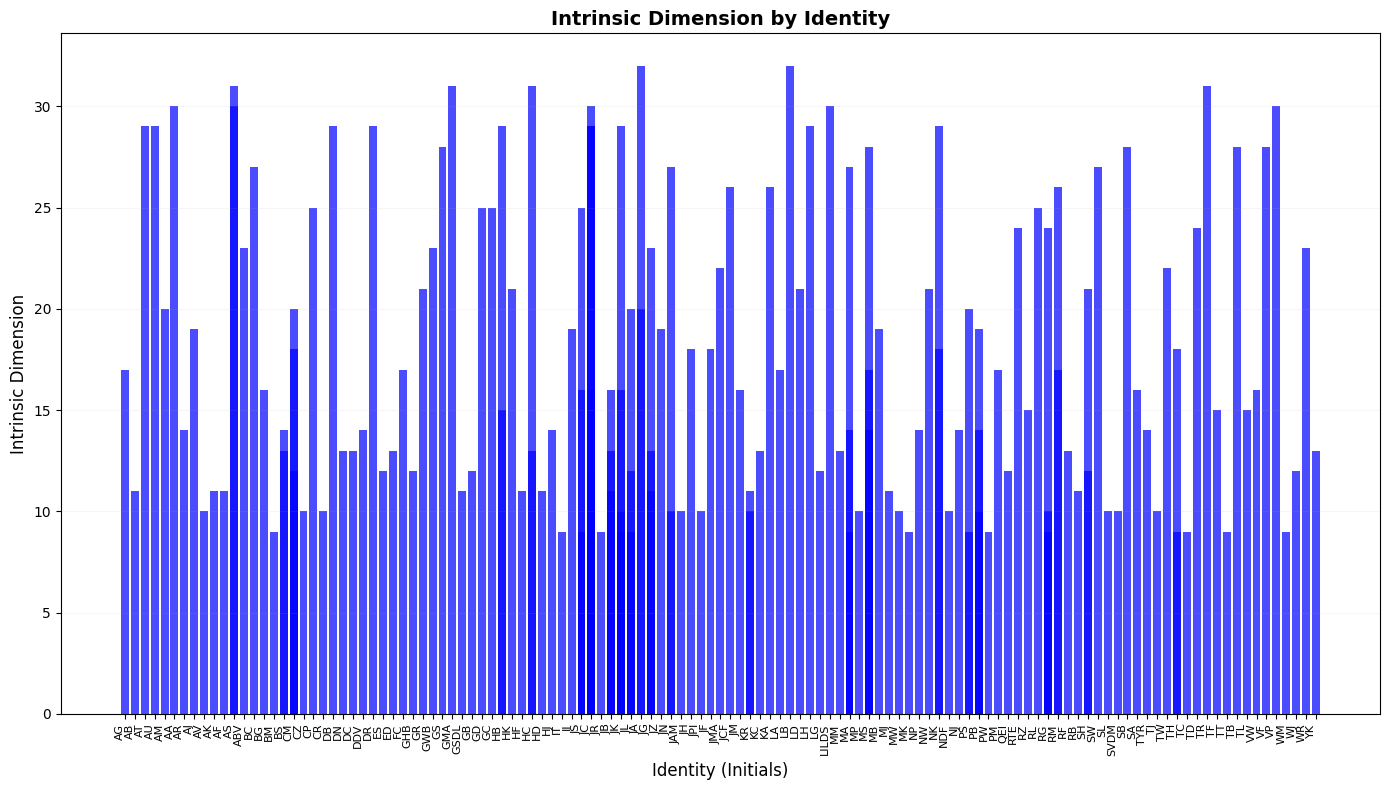

In [17]:
plt.figure(figsize=(14, 8))
identities = list(intrinsic_dim.keys())
dimensions = list(intrinsic_dim.values())
initials = [''.join([part[0].upper() for part in name.split()]) for name in identities]

plt.bar(initials, dimensions, color='blue', alpha=0.7)
plt.title('Intrinsic Dimension by Identity', fontsize=14, fontweight='bold')
plt.xlabel('Identity (Initials)', fontsize=12)
plt.ylabel('Intrinsic Dimension', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.grid(True, alpha=0.1, axis='y')
plt.tight_layout()
plt.show()

Plot by the name

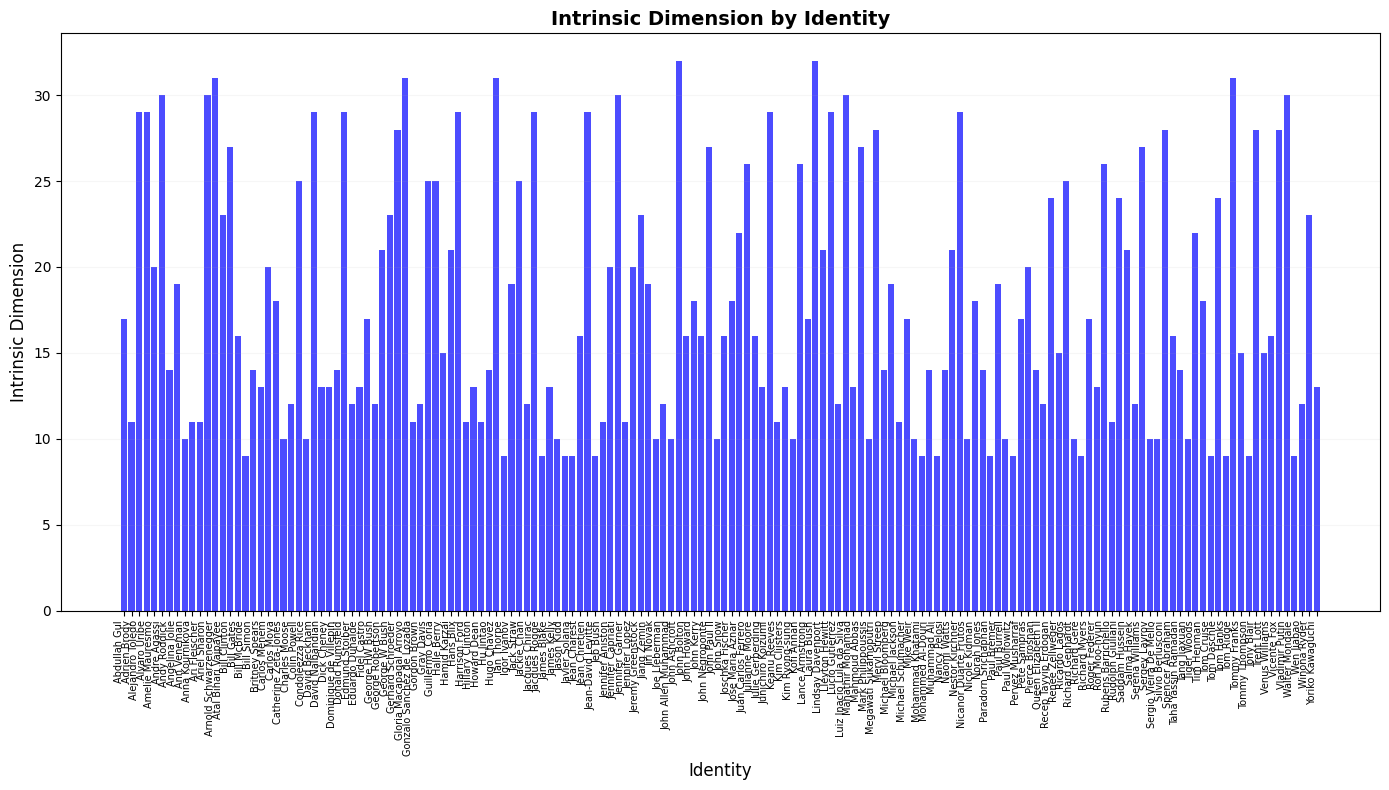

In [18]:
plt.figure(figsize=(14, 8))
identities = list(intrinsic_dim.keys())
dimensions = list(intrinsic_dim.values())

plt.bar(identities, dimensions, color='blue', alpha=0.7)
plt.title('Intrinsic Dimension by Identity', fontsize=14, fontweight='bold')
plt.xlabel('Identity', fontsize=12)
plt.ylabel('Intrinsic Dimension', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=7)
plt.grid(True, alpha=0.1, axis='y')
plt.tight_layout()
plt.show()

## 6. Visualization Clusters

Number of clusters: 158


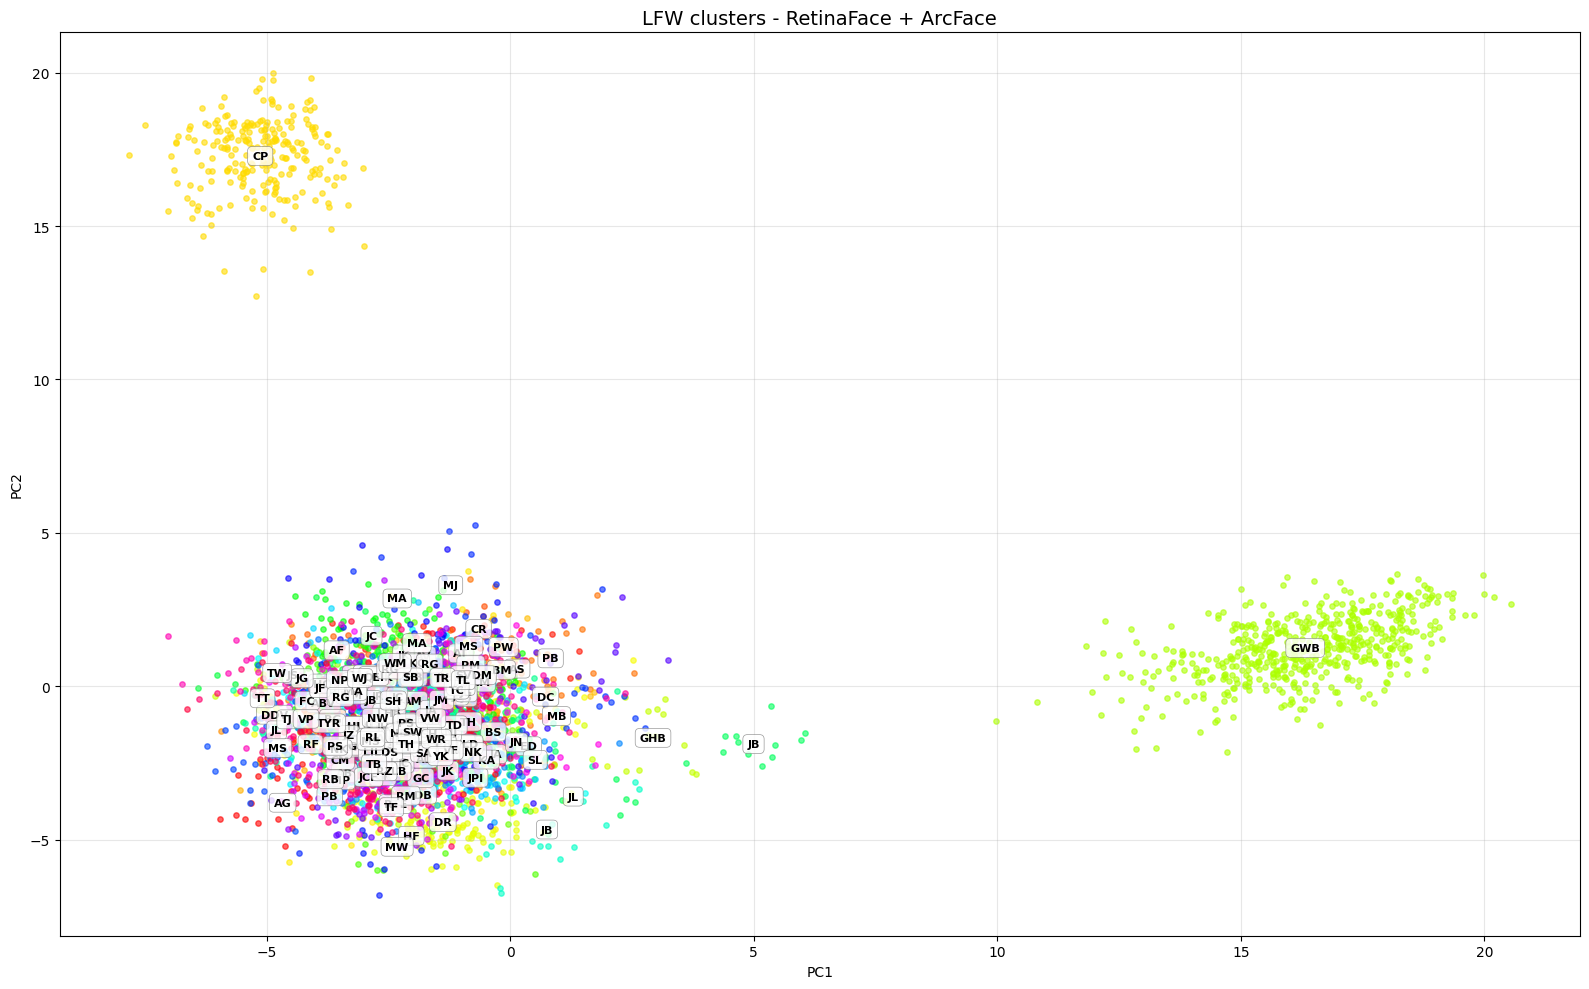

In [19]:
pca_2d = PCA(n_components=2)
emb_2d = pca_2d.fit_transform(embeddings)
centroids_2d = pca_2d.transform(np.array([cluster_stats[name]['centroid'] for name in cluster_stats.keys()]))

num_clusters = len(np.unique(valid_labels))
print(f"Number of clusters: {num_clusters}")
colors = plt.cm.hsv(np.linspace(0, 1, num_clusters))

plt.figure(figsize=(16, 10))
for idx, lbl in enumerate(np.unique(valid_labels)):
    cluster_points = emb_2d[valid_labels==lbl]
    plt.scatter(cluster_points[:,0], cluster_points[:,1], s=15, alpha=0.6, color=colors[idx]) #cluster_points[:,0], cluster_points[:,1] = x and y coordinates
    centroid_2d = cluster_points.mean(axis=0) #centroid in 2d

    name_parts = label_names[lbl].split() #name initials
    initials = ''.join([part[0].upper() for part in name_parts])
    plt.text(centroid_2d[0], centroid_2d[1], initials, fontsize=8, ha='center', va='center',bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor='gray', linewidth=0.5),fontweight='bold')

plt.title("LFW clusters - RetinaFace + ArcFace", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


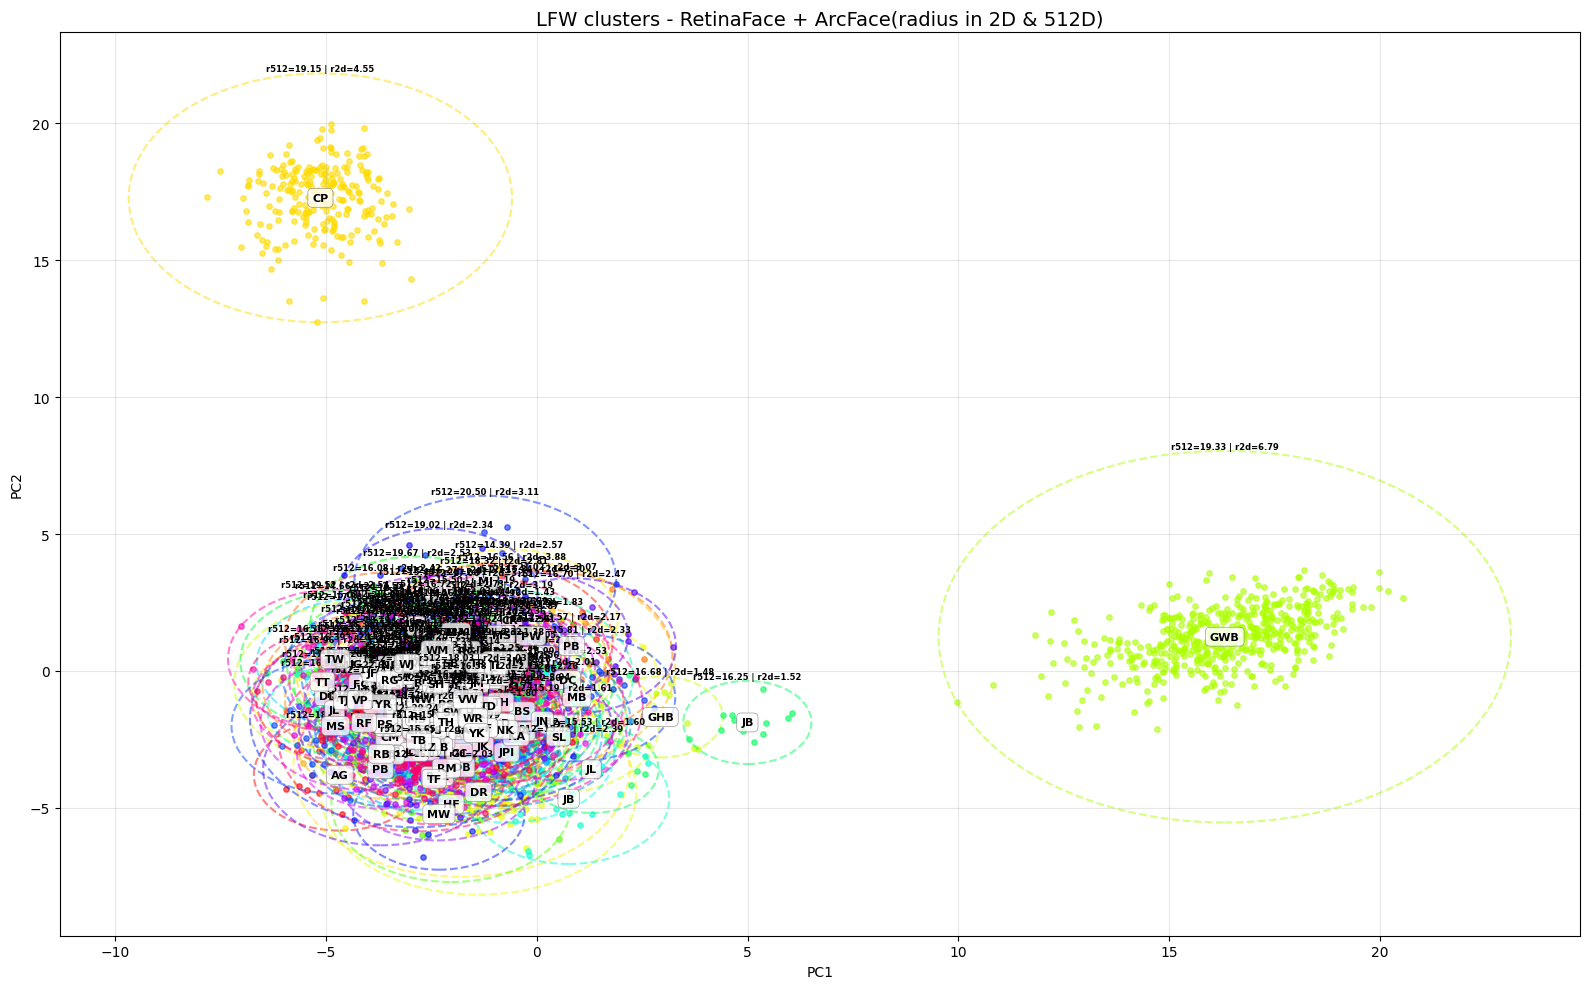

In [20]:
#same figure but with radius circles
plt.figure(figsize=(16, 10))
for idx, lbl in enumerate(np.unique(valid_labels)):
    cluster_points = emb_2d[valid_labels==lbl]
    plt.scatter(cluster_points[:,0], cluster_points[:,1], s=15, alpha=0.6, color=colors[idx])
    identity_name = label_names[lbl]
    centroid_2d = cluster_points.mean(axis=0) #centroid cluster in 2D space

    distances_2d = np.linalg.norm(cluster_points - centroid_2d, axis=1) #max radius in 2D
    radius_2d = distances_2d.max()
    radius_512d = cluster_stats[identity_name]['radius']# radius in original 512D space

    circle = plt.Circle(centroid_2d, radius_2d, color=colors[idx], fill=False, linewidth=1.5, linestyle='--', alpha=0.5) #circle
    plt.gca().add_patch(circle)

    name_parts = identity_name.split()#name initials
    initials = ''.join([part[0].upper() for part in name_parts])
    plt.text(centroid_2d[0], centroid_2d[1], initials, fontsize=8, ha='center', va='center',bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor='gray', linewidth=0.5),fontweight='bold')

    #show radius in 512D and 2D PCA
    plt.text(centroid_2d[0], centroid_2d[1] + radius_2d, f'r512={radius_512d:.2f} | r2d={radius_2d:.2f}', fontsize=6, ha='center', va='bottom', color="black", fontweight='bold')

plt.title("LFW clusters - RetinaFace + ArcFace(radius in 2D & 512D)", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Lets see the images of these people GWB and CP

In [21]:
#index labels
gwb_label = int(np.where(label_names == "George W Bush")[0][0])
cp_label = int(np.where(label_names == "Colin Powell")[0][0])
print("Label de George W Bush:", gwb_label)
print("Label de Colin Powell:", cp_label)

Label de George W Bush: 35
Label de Colin Powell: 23


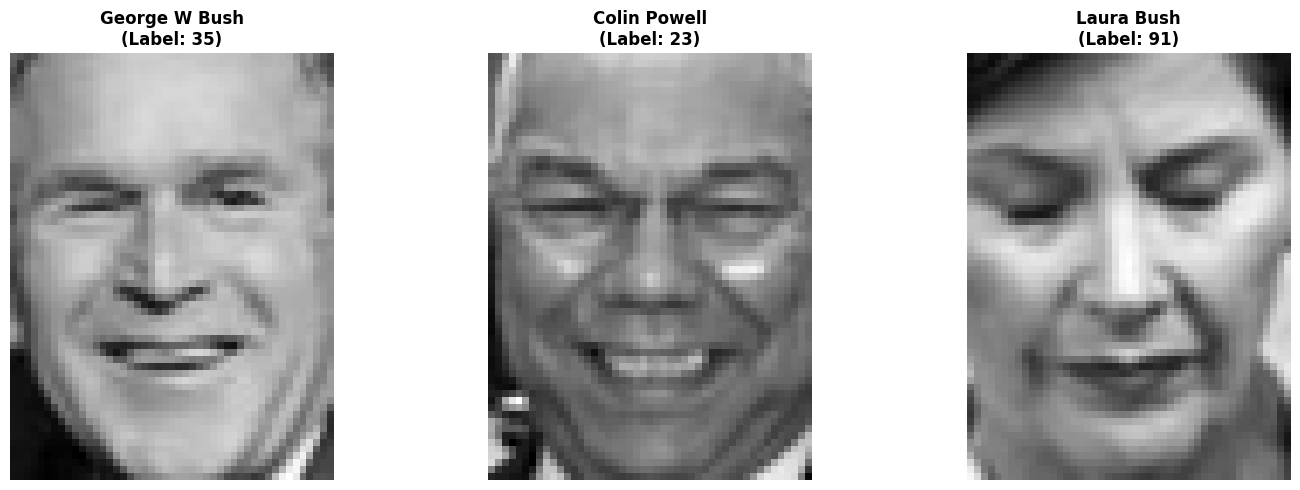

George W Bush (Label 35): 530 images in dataset
Colin Powell (Label 23): 236 images in dataset
Laura Bush (Label 91): 41 images in dataset


In [22]:
#indices for each person
gwb_indices = np.where(valid_labels == gwb_label)[0]
cp_indices = np.where(valid_labels == cp_label)[0]

other_labels = np.setdiff1d(np.unique(valid_labels), [gwb_label, cp_label]) #another person
random_person_label = np.random.choice(other_labels)
other_indices = np.where(valid_labels == random_person_label)[0]

gwb_img_idx = np.random.choice(gwb_indices) #random img for each one
cp_img_idx = np.random.choice(cp_indices)
other_img_idx = np.random.choice(other_indices)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(images[gwb_img_idx], cmap='gray') #george
axes[0].set_title(f'George W Bush\n(Label: {gwb_label})', fontsize=12, fontweight='bold')
axes[0].axis('off')
axes[1].imshow(images[cp_img_idx], cmap='gray') #colin
axes[1].set_title(f'Colin Powell\n(Label: {cp_label})', fontsize=12, fontweight='bold')
axes[1].axis('off')
axes[2].imshow(images[other_img_idx], cmap='gray') #other
axes[2].set_title(f'{label_names[random_person_label]}\n(Label: {random_person_label})', fontsize=12, fontweight='bold')
axes[2].axis('off')
plt.tight_layout()
plt.show()

print(f"George W Bush (Label {gwb_label}): {len(gwb_indices)} images in dataset")
print(f"Colin Powell (Label {cp_label}): {len(cp_indices)} images in dataset")
print(f"{label_names[random_person_label]} (Label {random_person_label}): {len(other_indices)} images in dataset")

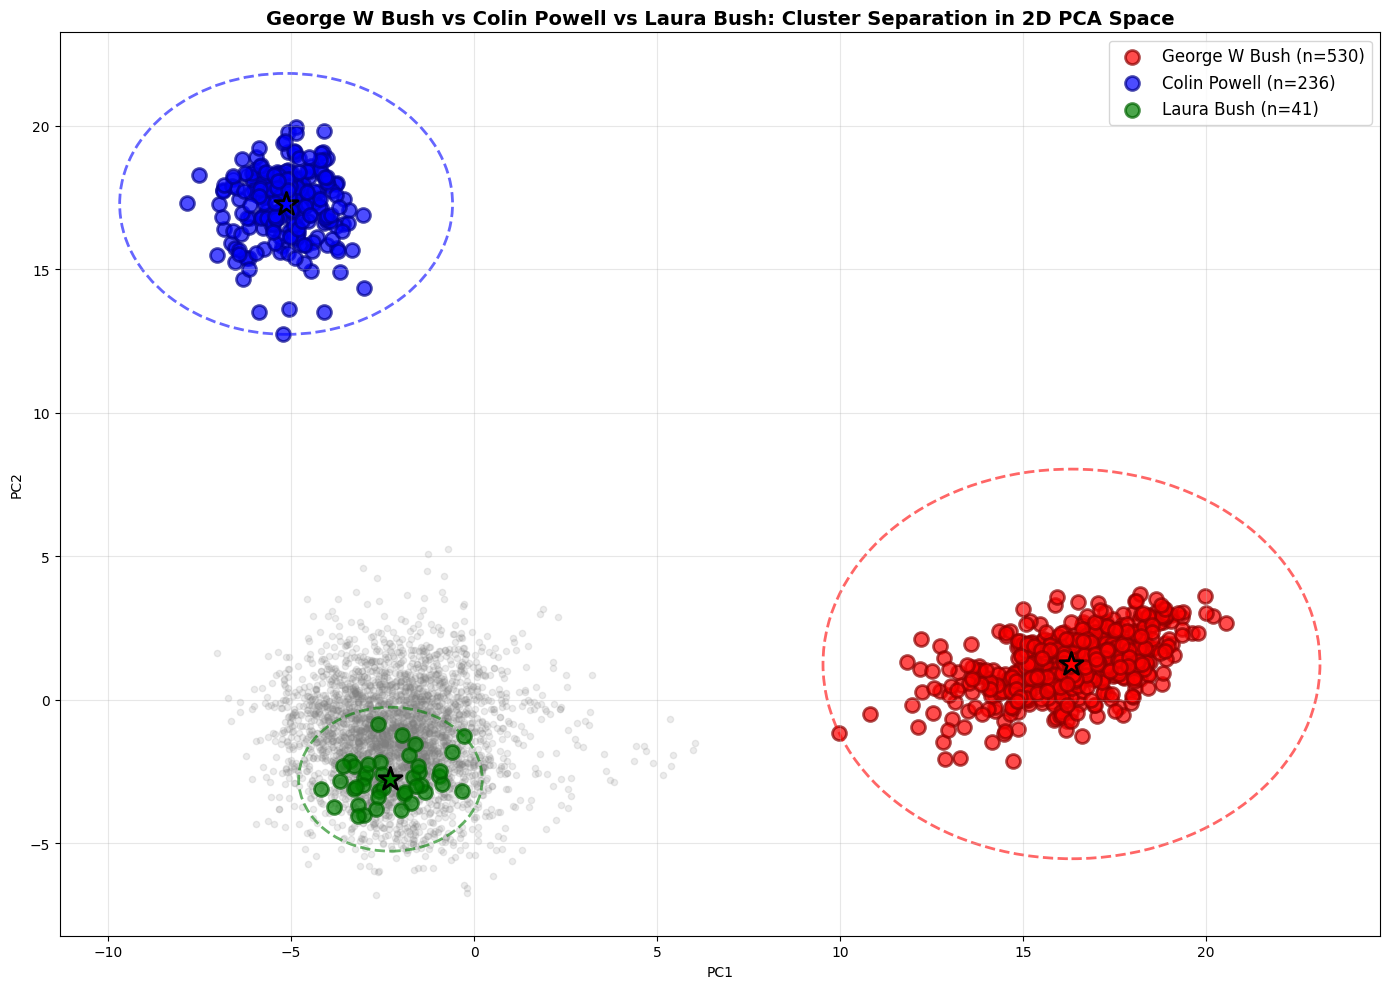

In [23]:
third_person_label = random_person_label #the same as before SERGIO
third_name = label_names[third_person_label]
third_indices = np.where(valid_labels == third_person_label)[0]

#2d projections
gwb_2d = emb_2d[valid_labels == gwb_label]
cp_2d = emb_2d[valid_labels == cp_label]
third_2d = emb_2d[valid_labels == third_person_label]

#clusters
plt.figure(figsize=(14, 10))
for lbl in np.unique(valid_labels):
    if lbl not in [gwb_label, cp_label, third_person_label]:
        cluster_points = emb_2d[valid_labels == lbl]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=20, alpha=0.15, color='gray', label=None)
plt.scatter(gwb_2d[:, 0], gwb_2d[:, 1], s=100, alpha=0.7, color='red', edgecolors='darkred', linewidth=2, label=f'George W Bush (n={len(gwb_2d)})')
plt.scatter(cp_2d[:, 0], cp_2d[:, 1], s=100, alpha=0.7, color='blue', edgecolors='darkblue', linewidth=2, label=f'Colin Powell (n={len(cp_2d)})')
plt.scatter(third_2d[:, 0], third_2d[:, 1], s=100, alpha=0.7, color='green', edgecolors='darkgreen', linewidth=2, label=f'{third_name} (n={len(third_2d)})')

#centroids
gwb_centroid = gwb_2d.mean(axis=0)
cp_centroid = cp_2d.mean(axis=0)
third_centroid = third_2d.mean(axis=0)
plt.scatter(*gwb_centroid, s=300, marker='*', color='red', edgecolors='black', linewidth=2)
plt.scatter(*cp_centroid, s=300, marker='*', color='blue', edgecolors='black', linewidth=2)
plt.scatter(*third_centroid, s=300, marker='*', color='green', edgecolors='black', linewidth=2)

#circles
gwb_radius_2d = np.linalg.norm(gwb_2d - gwb_centroid, axis=1).max()
cp_radius_2d = np.linalg.norm(cp_2d - cp_centroid, axis=1).max()
third_radius_2d = np.linalg.norm(third_2d - third_centroid, axis=1).max()
circle_gwb = plt.Circle(gwb_centroid, gwb_radius_2d, color='red', fill=False, linewidth=2, linestyle='--', alpha=0.6)
circle_cp = plt.Circle(cp_centroid, cp_radius_2d, color='blue', fill=False, linewidth=2, linestyle='--', alpha=0.6)
circle_third = plt.Circle(third_centroid, third_radius_2d, color='green', fill=False, linewidth=2, linestyle='--', alpha=0.6)
plt.gca().add_patch(circle_gwb)
plt.gca().add_patch(circle_cp)
plt.gca().add_patch(circle_third)

plt.title(f'George W Bush vs Colin Powell vs {third_name}: Cluster Separation in 2D PCA Space', fontsize=14, fontweight='bold')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [24]:
print("="*70)
print("GEORGE W BUSH CLUSTER STATISTICS:")
print("="*70)
print(f"Number of images: {len(gwb_2d)}")
print(f"Cluster radius (512D): {cluster_stats['George W Bush']['radius']}")
print(f"Cluster dispersion (512D): {cluster_stats['George W Bush']['dispersion']}")
print(f"Intrinsic dimension: {intrinsic_dim['George W Bush']}")
print(f"Cluster radius (2D PCA): {gwb_radius_2d}")
print()

print("="*70)
print("COLIN POWELL CLUSTER STATISTICS:")
print("="*70)
print(f"Number of images: {len(cp_2d)}")
print(f"Cluster radius (512D): {cluster_stats['Colin Powell']['radius']}")
print(f"Cluster dispersion (512D): {cluster_stats['Colin Powell']['dispersion']}")
print(f"Intrinsic dimension: {intrinsic_dim['Colin Powell']}")
print(f"Cluster radius (2D PCA): {cp_radius_2d}")
print()

print("="*70)
print(f"{third_name.upper()} CLUSTER STATISTICS:")
print("="*70)
print(f"Number of images: {len(third_2d)}")
print(f"Cluster radius (512D): {cluster_stats[third_name]['radius']}")
print(f"Cluster dispersion (512D): {cluster_stats[third_name]['dispersion']}")
print(f"Intrinsic dimension: {intrinsic_dim[third_name]}")
print(f"Cluster radius (2D PCA): {third_radius_2d}")
print()

print("="*70)
print("COSINE SIMILARITY BETWEEN CENTROIDS:")
print("="*70)
gwb_centroid_512d = cluster_stats['George W Bush']['centroid']
cp_centroid_512d = cluster_stats['Colin Powell']['centroid']
third_centroid_512d = cluster_stats[third_name]['centroid']
sim_gwb_cp = cosine_similarity(gwb_centroid_512d.reshape(1, -1), cp_centroid_512d.reshape(1, -1))[0, 0]
sim_gwb_third = cosine_similarity(gwb_centroid_512d.reshape(1, -1), third_centroid_512d.reshape(1, -1))[0, 0]
sim_cp_third = cosine_similarity(cp_centroid_512d.reshape(1, -1), third_centroid_512d.reshape(1, -1))[0, 0]
print(f"George W Bush vs Colin Powell: {sim_gwb_cp}")
print(f"George W Bush vs {third_name}: {sim_gwb_third}")
print(f"Colin Powell vs {third_name}: {sim_cp_third}")
print()

print("="*70)
print("Euclidean distances between centroids:")
print("="*70)
print(f"George W Bush to Colin Powell: {np.linalg.norm(gwb_centroid_512d - cp_centroid_512d)}")
print(f"George W Bush to {third_name}: {np.linalg.norm(gwb_centroid_512d - third_centroid_512d)}")
print(f"Colin Powell to {third_name}: {np.linalg.norm(cp_centroid_512d - third_centroid_512d)}")

GEORGE W BUSH CLUSTER STATISTICS:
Number of images: 530
Cluster radius (512D): 19.33111572265625
Cluster dispersion (512D): 1.608689308166504
Intrinsic dimension: 23
Cluster radius (2D PCA): 6.788702964782715

COLIN POWELL CLUSTER STATISTICS:
Number of images: 236
Cluster radius (512D): 19.149478912353516
Cluster dispersion (512D): 1.5028448104858398
Intrinsic dimension: 25
Cluster radius (2D PCA): 4.54693078994751

LAURA BUSH CLUSTER STATISTICS:
Number of images: 41
Cluster radius (512D): 18.458600997924805
Cluster dispersion (512D): 1.6061269044876099
Intrinsic dimension: 32
Cluster radius (2D PCA): 2.507523536682129

COSINE SIMILARITY BETWEEN CENTROIDS:
George W Bush vs Colin Powell: 0.0016432572156190872
George W Bush vs Laura Bush: -0.00024970807135105133
Colin Powell vs Laura Bush: -0.059730254113674164

Euclidean distances between centroids:
George W Bush to Colin Powell: 26.908973693847656
George W Bush to Laura Bush: 25.504638671875
Colin Powell to Laura Bush: 26.3297367095947

In [25]:
individuals = ['George W Bush', 'Colin Powell', third_name]
short_names = ['GWB', 'CP', third_name.split()[0][:2].upper()]
colors_bar = ['red', 'blue', 'green']

metrics = {
    'num_images': [len(gwb_2d), len(cp_2d), len(third_2d)],
    'radius_512d': [cluster_stats[name]['radius'] for name in individuals],
    'dispersion_512d': [cluster_stats[name]['dispersion'] for name in individuals],
    'intrinsic_dims': [intrinsic_dim[name] for name in individuals],
    'radius_2d': [gwb_radius_2d, cp_radius_2d, third_radius_2d]
}

cos_sim_matrix = np.array([[1.0, sim_gwb_cp, sim_gwb_third],
                           [sim_gwb_cp, 1.0, sim_cp_third],
                           [sim_gwb_third, sim_cp_third, 1.0]])

eucl_dist_matrix = np.array([[0, np.linalg.norm(gwb_centroid_512d - cp_centroid_512d), np.linalg.norm(gwb_centroid_512d - third_centroid_512d)],
                             [np.linalg.norm(gwb_centroid_512d - cp_centroid_512d), 0, np.linalg.norm(cp_centroid_512d - third_centroid_512d)],
                             [np.linalg.norm(gwb_centroid_512d - third_centroid_512d), np.linalg.norm(cp_centroid_512d - third_centroid_512d), 0]])

/tmp/ipython-input-2028521394.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


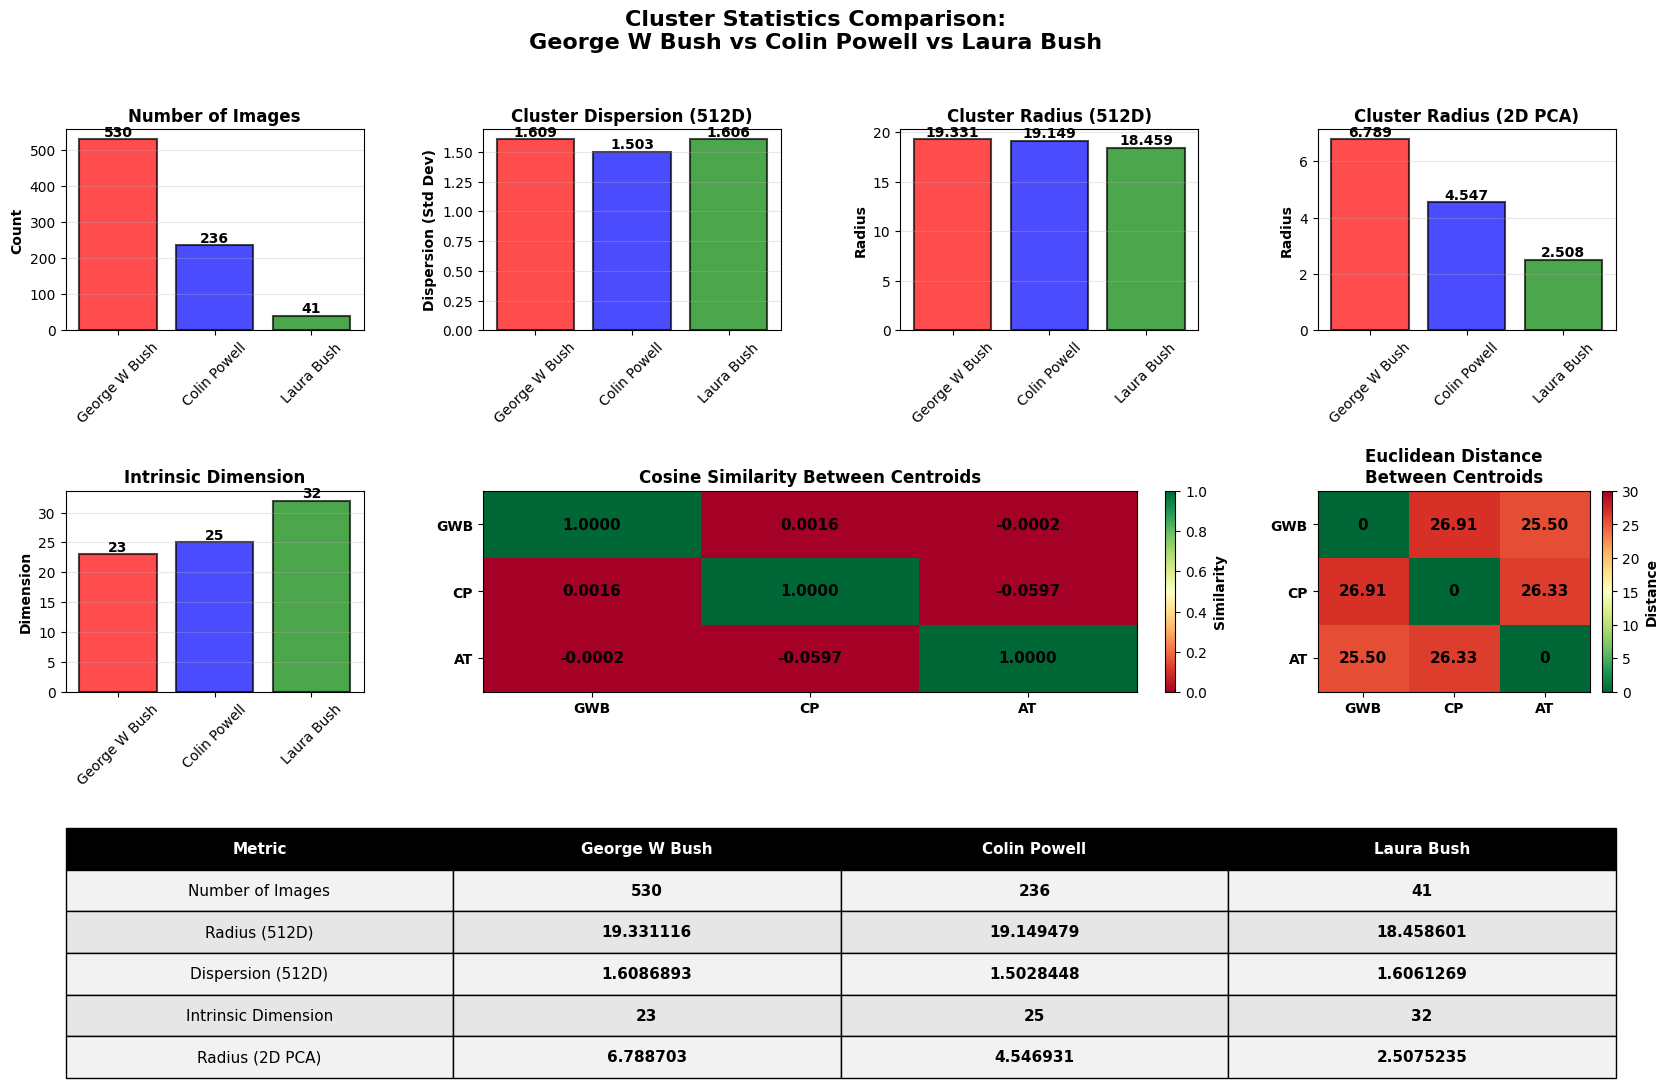

In [26]:
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 4, hspace=0.8, wspace=0.4)

#number of images
ax1 = fig.add_subplot(gs[0, 0])
bars1 = ax1.bar(individuals, metrics['num_images'], color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Count', fontweight='bold')
ax1.set_title('Number of Images', fontweight='bold', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
for bar, val in zip(bars1, metrics['num_images']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{val}',ha='center', va='bottom', fontweight='bold', fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

#cluster dispersion 512D
ax2 = fig.add_subplot(gs[0, 1])
bars2 = ax2.bar(individuals, metrics['dispersion_512d'], color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Dispersion (Std Dev)', fontweight='bold')
ax2.set_title('Cluster Dispersion (512D)', fontweight='bold', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
for bar, val in zip(bars2, metrics['dispersion_512d']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{val:.3f}',ha='center', va='bottom', fontweight='bold', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

#cluster radius 512D
ax3 = fig.add_subplot(gs[0, 2])
bars3 = ax3.bar(individuals, metrics['radius_512d'], color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Radius', fontweight='bold')
ax3.set_title('Cluster Radius (512D)', fontweight='bold', fontsize=12)
ax3.tick_params(axis='x', rotation=45)
for bar, val in zip(bars3, metrics['radius_512d']):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height, f'{val:.3f}',ha='center', va='bottom', fontweight='bold', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

#cluster radius 2D PCA
ax4 = fig.add_subplot(gs[0, 3])
bars4 = ax4.bar(individuals, metrics['radius_2d'], color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Radius', fontweight='bold')
ax4.set_title('Cluster Radius (2D PCA)', fontweight='bold', fontsize=12)
ax4.tick_params(axis='x', rotation=45)
for bar, val in zip(bars4, metrics['radius_2d']):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height, f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

#intrinsic dimension
ax5 = fig.add_subplot(gs[1, 0])
bars5 = ax5.bar(individuals, metrics['intrinsic_dims'], color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)
ax5.set_ylabel('Dimension', fontweight='bold')
ax5.set_title('Intrinsic Dimension', fontweight='bold', fontsize=12)
ax5.tick_params(axis='x', rotation=45)
for bar, val in zip(bars5, metrics['intrinsic_dims']):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height, f'{val}',ha='center', va='bottom', fontweight='bold', fontsize=10)
ax5.grid(True, alpha=0.3, axis='y')

#cosine similarity
ax6 = fig.add_subplot(gs[1, 1:3])
im1 = ax6.imshow(cos_sim_matrix, cmap='RdYlGn', vmin=0, vmax=1, aspect='auto')
ax6.set_xticks(range(3))
ax6.set_yticks(range(3))
short_names = ['GWB', 'CP', 'AT']
ax6.set_xticklabels(short_names, fontweight='bold')
ax6.set_yticklabels(short_names, fontweight='bold')
ax6.set_title('Cosine Similarity Between Centroids', fontweight='bold', fontsize=12)
for i in range(3):
    for j in range(3):
        text = ax6.text(j, i, f'{cos_sim_matrix[i, j]:.4f}',ha="center", va="center", color="black", fontsize=11, fontweight='bold')
cbar1 = plt.colorbar(im1, ax=ax6, fraction=0.046, pad=0.04)
cbar1.set_label('Similarity', fontweight='bold')

#euclidean distance heatmap
ax7 = fig.add_subplot(gs[1, 3])
im2 = ax7.imshow(eucl_dist_matrix, cmap='RdYlGn_r', vmin=0, vmax=30, aspect='auto')
ax7.set_xticks(range(3))
ax7.set_yticks(range(3))
ax7.set_xticklabels(short_names, fontweight='bold')
ax7.set_yticklabels(short_names, fontweight='bold')
ax7.set_title('Euclidean Distance\nBetween Centroids', fontweight='bold', fontsize=12)
for i in range(3):
    for j in range(3):
        val = eucl_dist_matrix[i, j]
        text = ax7.text(j, i, f'{val:.2f}' if val > 0 else '0',ha="center", va="center", color="black", fontsize=11, fontweight='bold')
cbar2 = plt.colorbar(im2, ax=ax7, fraction=0.046, pad=0.04)
cbar2.set_label('Distance', fontweight='bold')

#comparative metrics table
ax8 = fig.add_subplot(gs[2, :])
ax8.axis('tight')
ax8.axis('off')
table_data = [
    ['Metric', 'George W Bush', 'Colin Powell', third_name],
    ['Number of Images', metrics['num_images'][0], metrics['num_images'][1], metrics['num_images'][2]],
    ['Radius (512D)', metrics['radius_512d'][0], metrics['radius_512d'][1], metrics['radius_512d'][2]],
    ['Dispersion (512D)', metrics['dispersion_512d'][0], metrics['dispersion_512d'][1], metrics['dispersion_512d'][2]],
    ['Intrinsic Dimension', metrics['intrinsic_dims'][0], metrics['intrinsic_dims'][1], metrics['intrinsic_dims'][2]],
    ['Radius (2D PCA)', metrics['radius_2d'][0], metrics['radius_2d'][1], metrics['radius_2d'][2]],
]
table = ax8.table(cellText=table_data, cellLoc='center', loc='center',colWidths=[0.25, 0.25, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

#header row
for i in range(4):
    cell = table[(0, i)]
    cell.set_facecolor('black')
    cell.set_text_props(weight='bold', color='white')
#data rows with alternating colors
for i in range(1, 6):
    for j in range(4):
        cell = table[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#E7E6E6')
        else:
            cell.set_facecolor('#F2F2F2')
        if j > 0:  # Data columns
            cell.set_text_props(weight='bold')

plt.suptitle(f'Cluster Statistics Comparison:\nGeorge W Bush vs Colin Powell vs {third_name}',fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## 7. Cosine similarity between clusters

In [27]:
similarities = []
identity_pairs = []

for lbl1, lbl2 in zip(np.unique(valid_labels)[:-1], np.unique(valid_labels)[1:]):
    c1 = cluster_stats[label_names[lbl1]]['centroid']
    c2 = cluster_stats[label_names[lbl2]]['centroid']
    sim = cosine_similarity(c1.reshape(1,-1), c2.reshape(1,-1))[0,0]
    similarities.append(sim)
    identity_pairs.append(f"{label_names[lbl1][:3]} vs {label_names[lbl2][:3]}")
    print(f"Cosine similarity {label_names[lbl1]} vs {label_names[lbl2]}: {sim}")

Cosine similarity Abdullah Gul vs Adrien Brody: 0.02179517224431038
Cosine similarity Adrien Brody vs Alejandro Toledo: -0.05305986851453781
Cosine similarity Alejandro Toledo vs Alvaro Uribe: -0.018832603469491005
Cosine similarity Alvaro Uribe vs Amelie Mauresmo: -0.002500697039067745
Cosine similarity Amelie Mauresmo vs Andre Agassi: -0.07669686526060104
Cosine similarity Andre Agassi vs Andy Roddick: 0.06717928498983383
Cosine similarity Andy Roddick vs Angelina Jolie: -0.02267562784254551
Cosine similarity Angelina Jolie vs Ann Veneman: 0.02323143184185028
Cosine similarity Ann Veneman vs Anna Kournikova: 0.20611730217933655
Cosine similarity Anna Kournikova vs Ari Fleischer: 0.10760828852653503
Cosine similarity Ari Fleischer vs Ariel Sharon: -0.07481235265731812
Cosine similarity Ariel Sharon vs Arnold Schwarzenegger: 0.10506176948547363
Cosine similarity Arnold Schwarzenegger vs Atal Bihari Vajpayee: -0.00486011803150177
Cosine similarity Atal Bihari Vajpayee vs Bill Clinton: -

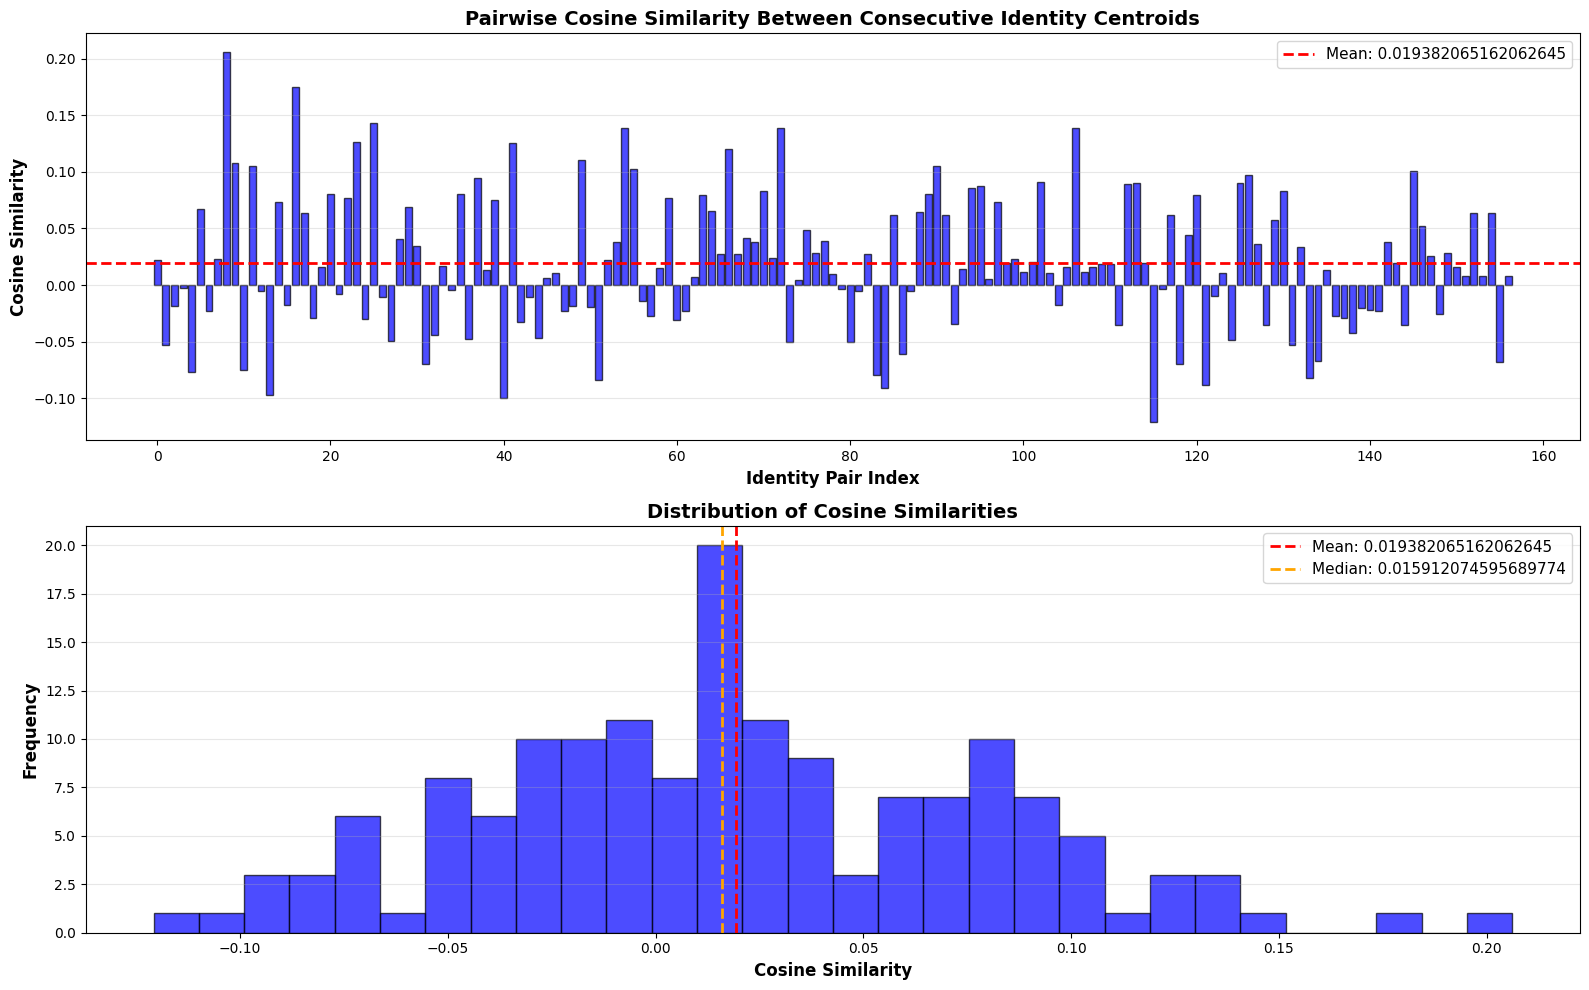

COSINE SIMILARITY STATISTICS (Consecutive Pairs):
Mean similarity: 0.019382065162062645
Median similarity: 0.015912074595689774
Std deviation: 0.0601167231798172
Min similarity: -0.12083020806312561
Max similarity: 0.20611730217933655


In [28]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

#cosine similarities
axes[0].bar(range(len(similarities)), similarities, color='blue', alpha=0.7, edgecolor='black')
axes[0].axhline(y=np.mean(similarities), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(similarities)}')
axes[0].set_xlabel('Identity Pair Index', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cosine Similarity', fontsize=12, fontweight='bold')
axes[0].set_title('Pairwise Cosine Similarity Between Consecutive Identity Centroids', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')
#distribution histogram
axes[1].hist(similarities, bins=30, color='blue', alpha=0.7, edgecolor='black')
axes[1].axvline(x=np.mean(similarities), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(similarities)}')
axes[1].axvline(x=np.median(similarities), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(similarities)}')
axes[1].set_xlabel('Cosine Similarity', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution of Cosine Similarities', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

#stats
print("="*70)
print("COSINE SIMILARITY STATISTICS (Consecutive Pairs):")
print("="*70)
print(f"Mean similarity: {np.mean(similarities)}")
print(f"Median similarity: {np.median(similarities)}")
print(f"Std deviation: {np.std(similarities)}")
print(f"Min similarity: {np.min(similarities)}")
print(f"Max similarity: {np.max(similarities)}")

## 8. Analyze cluster stats

In [29]:
#cluster data to DataFrame
cluster_stats_df = pd.DataFrame.from_dict(cluster_stats, orient='index')
print(cluster_stats_df.head())

                                                           centroid  \
Abdullah Gul      [-0.73390454, -1.2285999, 1.1693896, 0.0752135...   
Adrien Brody      [-0.8107771, 1.5052619, 0.6705888, 0.9059164, ...   
Alejandro Toledo  [-1.003852, -0.84795976, -0.32987225, -0.61221...   
Alvaro Uribe      [0.14562288, 1.0369306, -0.26325142, -0.666667...   
Amelie Mauresmo   [-0.5082676, -0.13569789, -0.49784112, -1.2521...   

                     radius  dispersion  num_images  
Abdullah Gul      18.119932    2.206607          19  
Adrien Brody      16.773529    1.393790          12  
Alejandro Toledo  18.316793    1.473149          39  
Alvaro Uribe      16.634136    1.279701          35  
Amelie Mauresmo   19.493586    1.870930          21  


In [30]:
intrinsic_dim_df = pd.DataFrame.from_dict(intrinsic_dim, orient='index', columns=['intrinsic_dimension'])
merged_df = intrinsic_dim_df.merge(cluster_stats_df, left_index=True, right_index=True)
print("Merged DataFrame created successfully")
print(merged_df.head())

Merged DataFrame created successfully
                  intrinsic_dimension  \
Abdullah Gul                       17   
Adrien Brody                       11   
Alejandro Toledo                   29   
Alvaro Uribe                       29   
Amelie Mauresmo                    20   

                                                           centroid  \
Abdullah Gul      [-0.73390454, -1.2285999, 1.1693896, 0.0752135...   
Adrien Brody      [-0.8107771, 1.5052619, 0.6705888, 0.9059164, ...   
Alejandro Toledo  [-1.003852, -0.84795976, -0.32987225, -0.61221...   
Alvaro Uribe      [0.14562288, 1.0369306, -0.26325142, -0.666667...   
Amelie Mauresmo   [-0.5082676, -0.13569789, -0.49784112, -1.2521...   

                     radius  dispersion  num_images  
Abdullah Gul      18.119932    2.206607          19  
Adrien Brody      16.773529    1.393790          12  
Alejandro Toledo  18.316793    1.473149          39  
Alvaro Uribe      16.634136    1.279701          35  
Amelie Mauresmo   

In [31]:
print("Summary Statistics for Merged DataFrame:")
print(merged_df[['intrinsic_dimension', 'radius', 'dispersion', 'num_images']].describe())

Summary Statistics for Merged DataFrame:
       intrinsic_dimension      radius  dispersion  num_images
count           158.000000  158.000000  158.000000  158.000000
mean             17.632911   17.617336    1.611170   27.367089
std               7.224652    2.188489    0.393334   47.598822
min               9.000000   13.514213    0.703262   10.000000
25%              11.000000   16.367250    1.342519   12.000000
50%              16.000000   17.333750    1.537381   17.000000
75%              24.000000   18.541245    1.803825   26.000000
max              32.000000   29.241362    3.383630  530.000000


In [32]:
print("\nIdentities with most consistent face embeddings (smallest radius):")
print(cluster_stats_df.sort_values(by='radius', ascending=True).head())

print("\nIdentities with least consistent face embeddings (largest radius):")
print(cluster_stats_df.sort_values(by='radius', ascending=False).head())

print("\nIdentities with least dispersed embeddings (smallest dispersion):")
print(cluster_stats_df.sort_values(by='dispersion', ascending=True).head())

print("\nIdentities with most dispersed embeddings (largest dispersion):")
print(cluster_stats_df.sort_values(by='dispersion', ascending=False).head())

print("\nIndividuals with the most images:")
print(cluster_stats_df.sort_values(by='num_images', ascending=False).head())


Identities with most consistent face embeddings (smallest radius):
                                                           centroid  \
Paul Burrell      [-0.090826005, 0.5141508, -1.30118, 0.6041637,...   
Jacques Rogge     [0.2698771, 0.5046526, 0.26977342, -1.5241728,...   
Dick Cheney       [0.6181472, 0.0007442747, -0.10075232, -0.3234...   
Yoriko Kawaguchi  [-1.1094157, 0.027234389, -0.3773158, 1.097761...   
Condoleezza Rice  [-0.8874872, -0.119344495, 0.0251702, -0.80404...   

                     radius  dispersion  num_images  
Paul Burrell      13.514213    1.521168          11  
Jacques Rogge     13.552886    1.280454          10  
Dick Cheney       13.570552    1.156209          14  
Yoriko Kawaguchi  14.220515    1.134910          14  
Condoleezza Rice  14.390482    0.703262          11  

Identities with least consistent face embeddings (largest radius):
                                                               centroid  \
Recep Tayyip Erdogan  [0.530579, 0.422

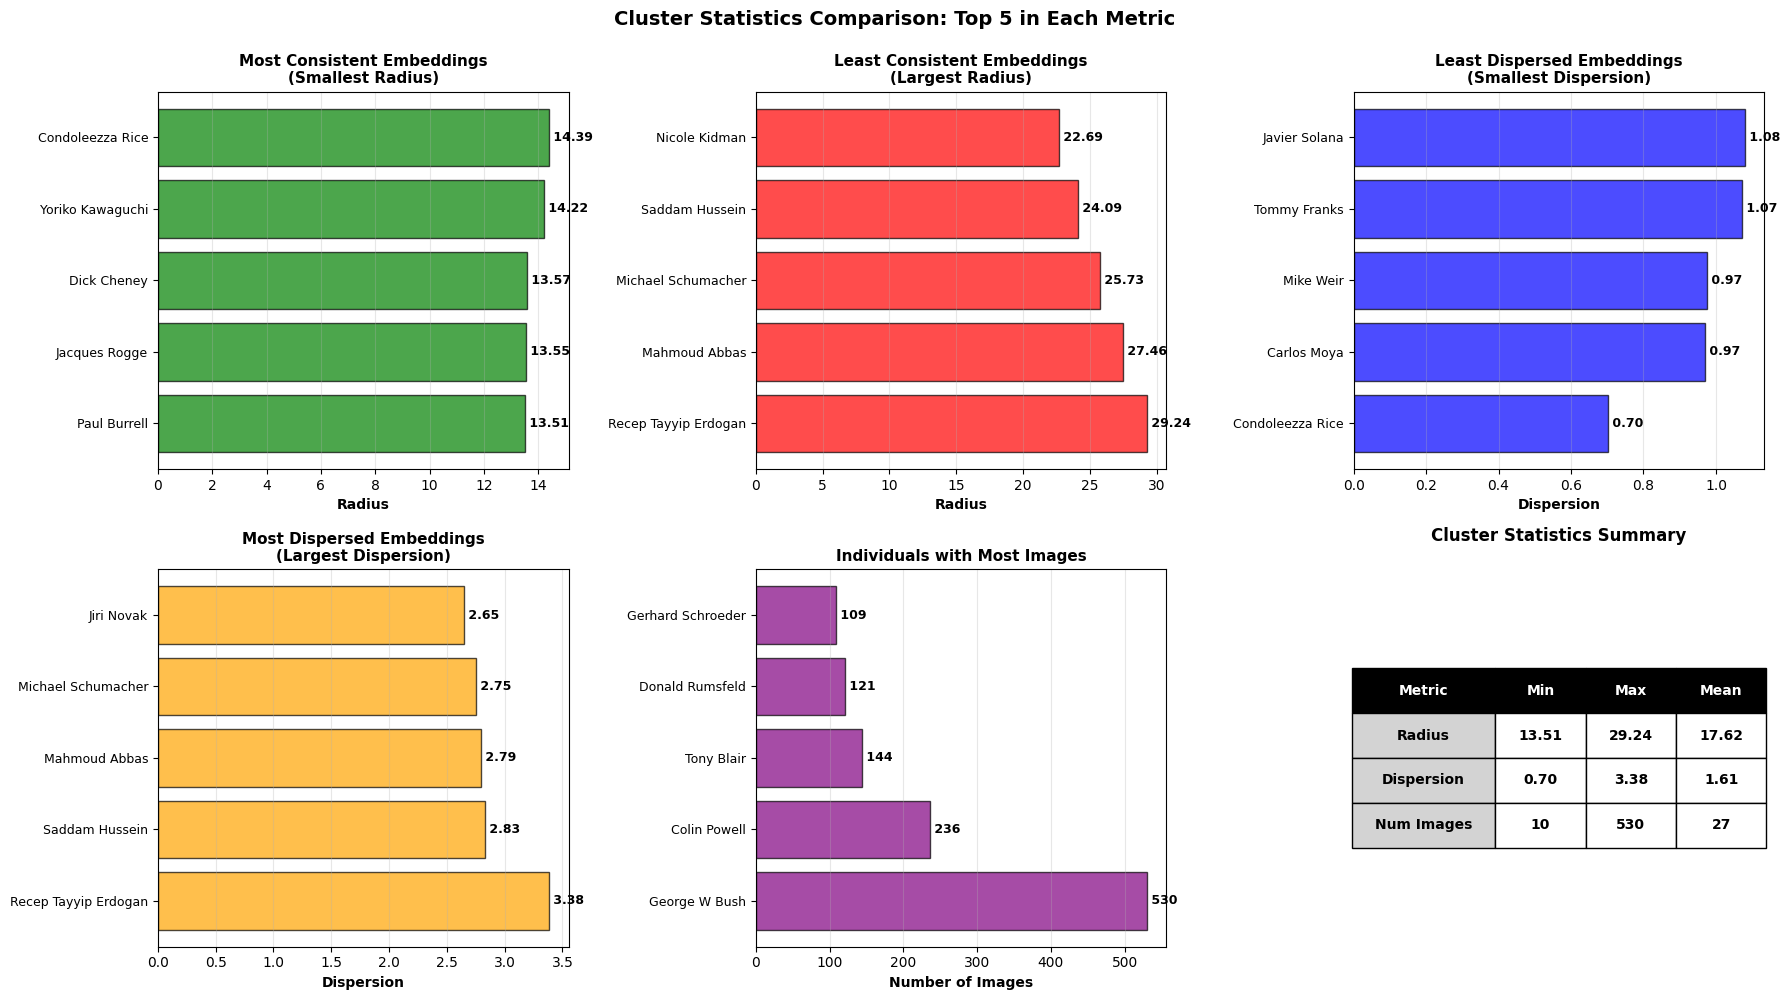

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

#smallest radius (most consistent)
smallest_radius = cluster_stats_df.sort_values(by='radius', ascending=True).head()
axes[0, 0].barh(range(len(smallest_radius)), smallest_radius['radius'], color='green', alpha=0.7, edgecolor='black')
axes[0, 0].set_yticks(range(len(smallest_radius)))
axes[0, 0].set_yticklabels(smallest_radius.index, fontsize=9)
axes[0, 0].set_xlabel('Radius', fontweight='bold')
axes[0, 0].set_title('Most Consistent Embeddings\n(Smallest Radius)', fontweight='bold', fontsize=11)
axes[0, 0].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(smallest_radius['radius']):
    axes[0, 0].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#largest radius (least consistent)
largest_radius = cluster_stats_df.sort_values(by='radius', ascending=False).head()
axes[0, 1].barh(range(len(largest_radius)), largest_radius['radius'], color='red', alpha=0.7, edgecolor='black')
axes[0, 1].set_yticks(range(len(largest_radius)))
axes[0, 1].set_yticklabels(largest_radius.index, fontsize=9)
axes[0, 1].set_xlabel('Radius', fontweight='bold')
axes[0, 1].set_title('Least Consistent Embeddings\n(Largest Radius)', fontweight='bold', fontsize=11)
axes[0, 1].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(largest_radius['radius']):
    axes[0, 1].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#smallest dispersion
smallest_dispersion = cluster_stats_df.sort_values(by='dispersion', ascending=True).head()
axes[0, 2].barh(range(len(smallest_dispersion)), smallest_dispersion['dispersion'], color='blue', alpha=0.7, edgecolor='black')
axes[0, 2].set_yticks(range(len(smallest_dispersion)))
axes[0, 2].set_yticklabels(smallest_dispersion.index, fontsize=9)
axes[0, 2].set_xlabel('Dispersion', fontweight='bold')
axes[0, 2].set_title('Least Dispersed Embeddings\n(Smallest Dispersion)', fontweight='bold', fontsize=11)
axes[0, 2].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(smallest_dispersion['dispersion']):
    axes[0, 2].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#largest dispersion
largest_dispersion = cluster_stats_df.sort_values(by='dispersion', ascending=False).head()
axes[1, 0].barh(range(len(largest_dispersion)), largest_dispersion['dispersion'], color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_yticks(range(len(largest_dispersion)))
axes[1, 0].set_yticklabels(largest_dispersion.index, fontsize=9)
axes[1, 0].set_xlabel('Dispersion', fontweight='bold')
axes[1, 0].set_title('Most Dispersed Embeddings\n(Largest Dispersion)', fontweight='bold', fontsize=11)
axes[1, 0].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(largest_dispersion['dispersion']):
    axes[1, 0].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#images
most_images = cluster_stats_df.sort_values(by='num_images', ascending=False).head()
axes[1, 1].barh(range(len(most_images)), most_images['num_images'], color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_yticks(range(len(most_images)))
axes[1, 1].set_yticklabels(most_images.index, fontsize=9)
axes[1, 1].set_xlabel('Number of Images', fontweight='bold')
axes[1, 1].set_title('Individuals with Most Images', fontweight='bold', fontsize=11)
axes[1, 1].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(most_images['num_images']):
    axes[1, 1].text(val, i, f' {int(val)}', va='center', fontweight='bold', fontsize=9)

#statistics table
axes[1, 2].axis('tight')
axes[1, 2].axis('off')
summary_data = [
    ['Metric', 'Min', 'Max', 'Mean'],
    ['Radius', f"{cluster_stats_df['radius'].min():.2f}", f"{cluster_stats_df['radius'].max():.2f}", f"{cluster_stats_df['radius'].mean():.2f}"],
    ['Dispersion', f"{cluster_stats_df['dispersion'].min():.2f}", f"{cluster_stats_df['dispersion'].max():.2f}", f"{cluster_stats_df['dispersion'].mean():.2f}"],
    ['Num Images', f"{int(cluster_stats_df['num_images'].min())}", f"{int(cluster_stats_df['num_images'].max())}", f"{int(cluster_stats_df['num_images'].mean())}"]
]
table = axes[1, 2].table(cellText=summary_data, cellLoc='center', loc='center', colWidths=[0.35, 0.22, 0.22, 0.22])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)
for i in range(4): #header
    table[(0, i)].set_facecolor('black')
    table[(0, i)].set_text_props(weight='bold', color='white')
for i in range(1, 4): #rows
    table[(i, 0)].set_facecolor('#D3D3D3')
    table[(i, 0)].set_text_props(weight='bold')
    for j in range(1, 4):
        table[(i, j)].set_facecolor('white' if i % 2 == 0 else 'white')
        table[(i, j)].set_text_props(weight='bold')
axes[1, 2].set_title('Cluster Statistics Summary', fontweight='bold', fontsize=12, pad=20)

plt.suptitle('Cluster Statistics Comparison: Top 5 in Each Metric', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

- **Smallest Radius:** small average distance of ther embeddings from their centroids = face embeddings are tightly clustered, so they have higher consistency across different imgs of the same person
- **Largest Radius:** largest average distance from their centroids. Face embeddings are more spread out, so they have less consistency or greater variation in their imgs
- **Smallest Dispersion:** so small deviation of distances from their centroids, so the variation in embedding consistency are very low
- **Largest Dispersion:** largest deviation of distances, so they have more variability in the consistency of their embeddings. High dispersion = wider range of conditions in the imgs (pose, light, expression...)
- **Most Images:** lead to larger radii or dispersion due to greater diversity

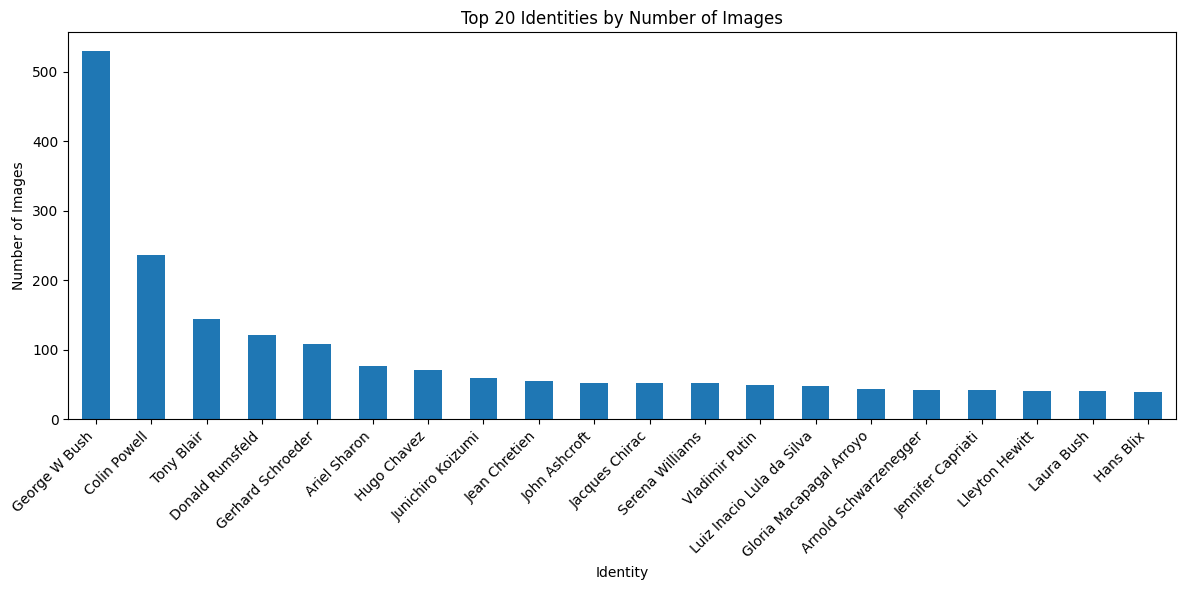

In [34]:
# number of imgs per identity bar plot
plt.figure(figsize=(12, 6))
top_n = 20  # Display top 20 identities
cluster_stats_df.sort_values(by='num_images', ascending=False).head(top_n)['num_images'].plot(kind='bar')
plt.title(f'Top {top_n} Identities by Number of Images')
plt.xlabel('Identity')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 9. Scatter Plot: Intrinsic Dimension vs. Cluster Dispersion

Higher intrinsic complexity in a person's image set often correlates with greater variability in the consistency of their face embeddings. The ArcFace model, while robust, shows signs of this increased challenge through higher dispersion values for identities with higher intrinsic dimensions.

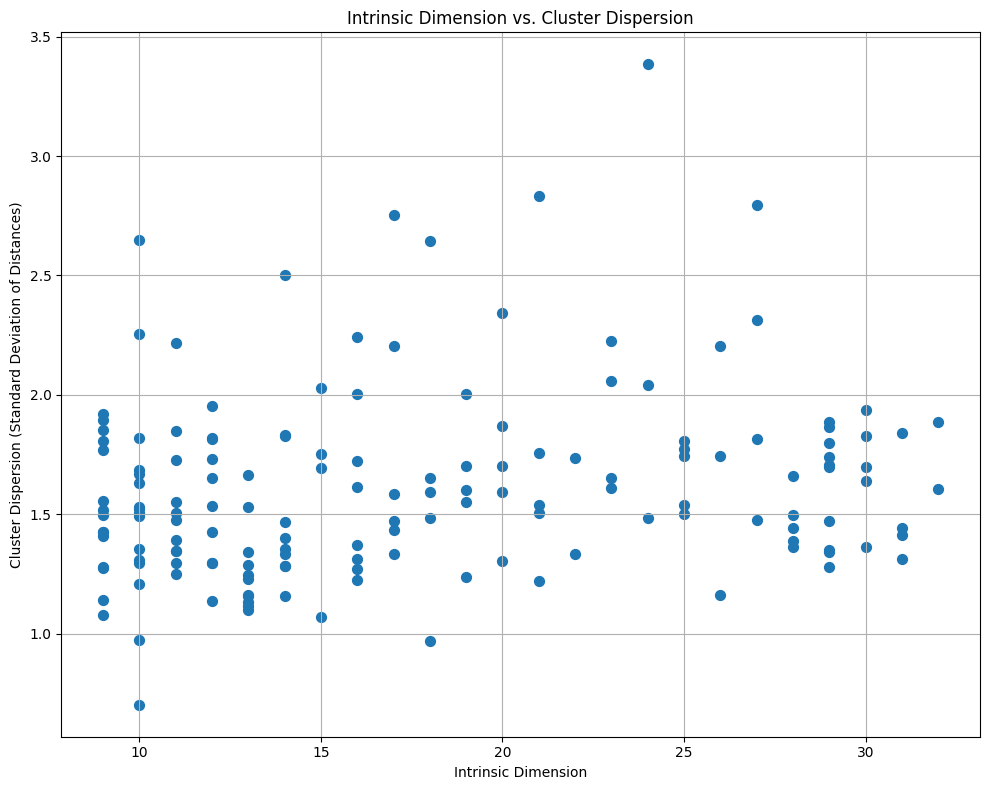

In [35]:
plt.figure(figsize=(10, 8))
plt.scatter(merged_df['intrinsic_dimension'], merged_df['dispersion'], s=50)
plt.title('Intrinsic Dimension vs. Cluster Dispersion')
plt.xlabel('Intrinsic Dimension')
plt.ylabel('Cluster Dispersion (Standard Deviation of Distances)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 10. Scatter Plot: Radius vs Dispersion


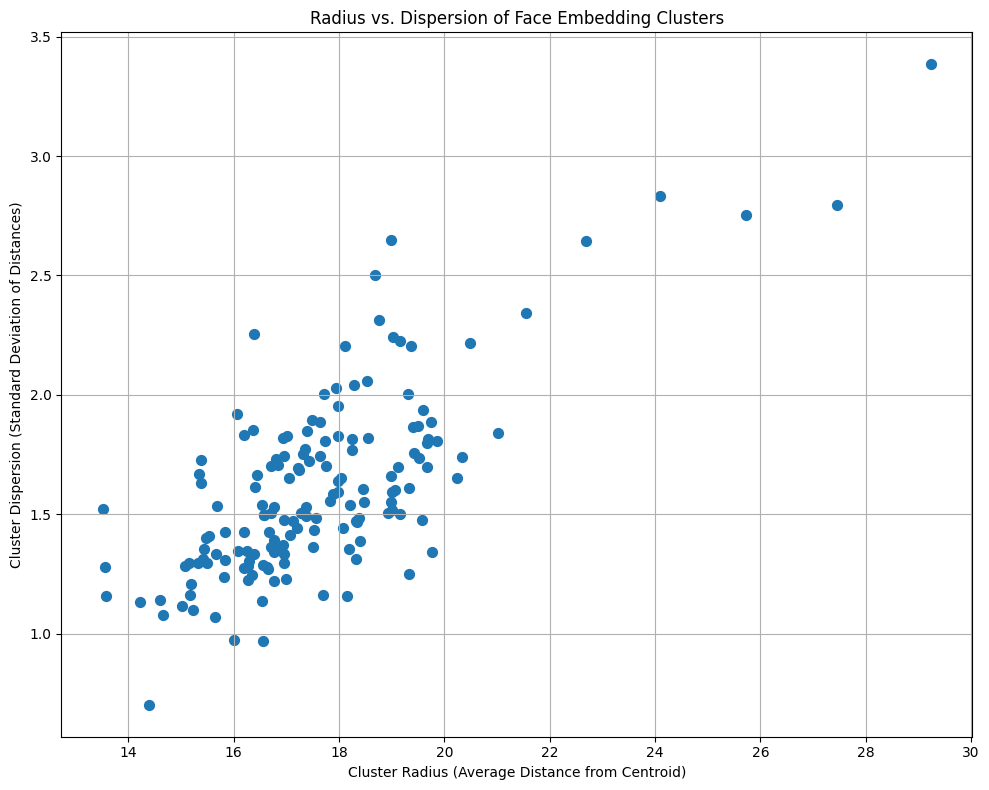

In [36]:
plt.figure(figsize=(10, 8))
plt.scatter(cluster_stats_df['radius'], cluster_stats_df['dispersion'], s=50)
plt.title('Radius vs. Dispersion of Face Embedding Clusters')
plt.xlabel('Cluster Radius (Average Distance from Centroid)')
plt.ylabel('Cluster Dispersion (Standard Deviation of Distances)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 11. Intrinsic Dimension of Clusters


In [37]:
intrinsic_dim_df = pd.DataFrame.from_dict(intrinsic_dim, orient='index', columns=['intrinsic_dimension'])
print("Intrinsic Dimensionality DataFrame Head:")
print(intrinsic_dim_df.head())

Intrinsic Dimensionality DataFrame Head:
                  intrinsic_dimension
Abdullah Gul                       17
Adrien Brody                       11
Alejandro Toledo                   29
Alvaro Uribe                       29
Amelie Mauresmo                    20


In [38]:
print("\nDescriptive Statistics for Intrinsic Dimensionality:")
print(intrinsic_dim_df['intrinsic_dimension'].describe())

print("\nIdentities with the 10 highest intrinsic dimensions:")
print(intrinsic_dim_df.sort_values(by='intrinsic_dimension', ascending=False).head(10))

print("\nIdentities with the 10 lowest intrinsic dimensions:")
print(intrinsic_dim_df.sort_values(by='intrinsic_dimension', ascending=True).head(10))


Descriptive Statistics for Intrinsic Dimensionality:
count    158.000000
mean      17.632911
std        7.224652
min        9.000000
25%       11.000000
50%       16.000000
75%       24.000000
max       32.000000
Name: intrinsic_dimension, dtype: float64

Identities with the 10 highest intrinsic dimensions:
                           intrinsic_dimension
John Ashcroft                               32
Laura Bush                                  32
Hugo Chavez                                 31
Gloria Macapagal Arroyo                     31
Arnold Schwarzenegger                       31
Tom Ridge                                   31
Vladimir Putin                              30
Luiz Inacio Lula da Silva                   30
Jennifer Capriati                           30
Andre Agassi                                30

Identities with the 10 lowest intrinsic dimensions:
                     intrinsic_dimension
Bill McBride                           9
Jacques Rogge                         


### Identities with High Intrinsic Dimensionality
exhibit a greater complexity or variability. This means that more principal components are needed to explain the variance within their respective clusters. This could be due to a wider range of poses, expressions, lighting conditions, or even image quality variations for these individuals in the LFW dataset.

### Identities with Low Intrinsic Dimensionality
their image clusters are less complex or more consistent. Fewer principal components are sufficient to capture the variance within their embeddings. This might imply that the images for these individuals are more uniform in terms of visual characteristics, or perhaps their facial features are inherently less variable across different images presented to the model.

In [39]:
top_10_high_intrinsic_dim_identities = intrinsic_dim_df.nlargest(10, 'intrinsic_dimension')
top_10_data = merged_df.loc[top_10_high_intrinsic_dim_identities.index][['intrinsic_dimension', 'radius', 'dispersion', 'num_images']]
print("\nMetrics for Identities with the 10 Highest Intrinsic Dimensions:")
print(top_10_data)


Metrics for Identities with the 10 Highest Intrinsic Dimensions:
                           intrinsic_dimension     radius  dispersion  \
John Ashcroft                               32  17.647785    1.885192   
Laura Bush                                  32  18.458601    1.606127   
Arnold Schwarzenegger                       31  21.017630    1.840780   
Gloria Macapagal Arroyo                     31  18.314327    1.312636   
Hugo Chavez                                 31  18.070490    1.441255   
Tom Ridge                                   31  17.063328    1.415096   
Andre Agassi                                30  17.511208    1.364748   
Ariel Sharon                                30  17.005806    1.827244   
Jennifer Capriati                           30  19.603964    1.934887   
Luiz Inacio Lula da Silva                   30  17.983412    1.641183   

                           num_images  
John Ashcroft                      53  
Laura Bush                         41  
Arnold Sch

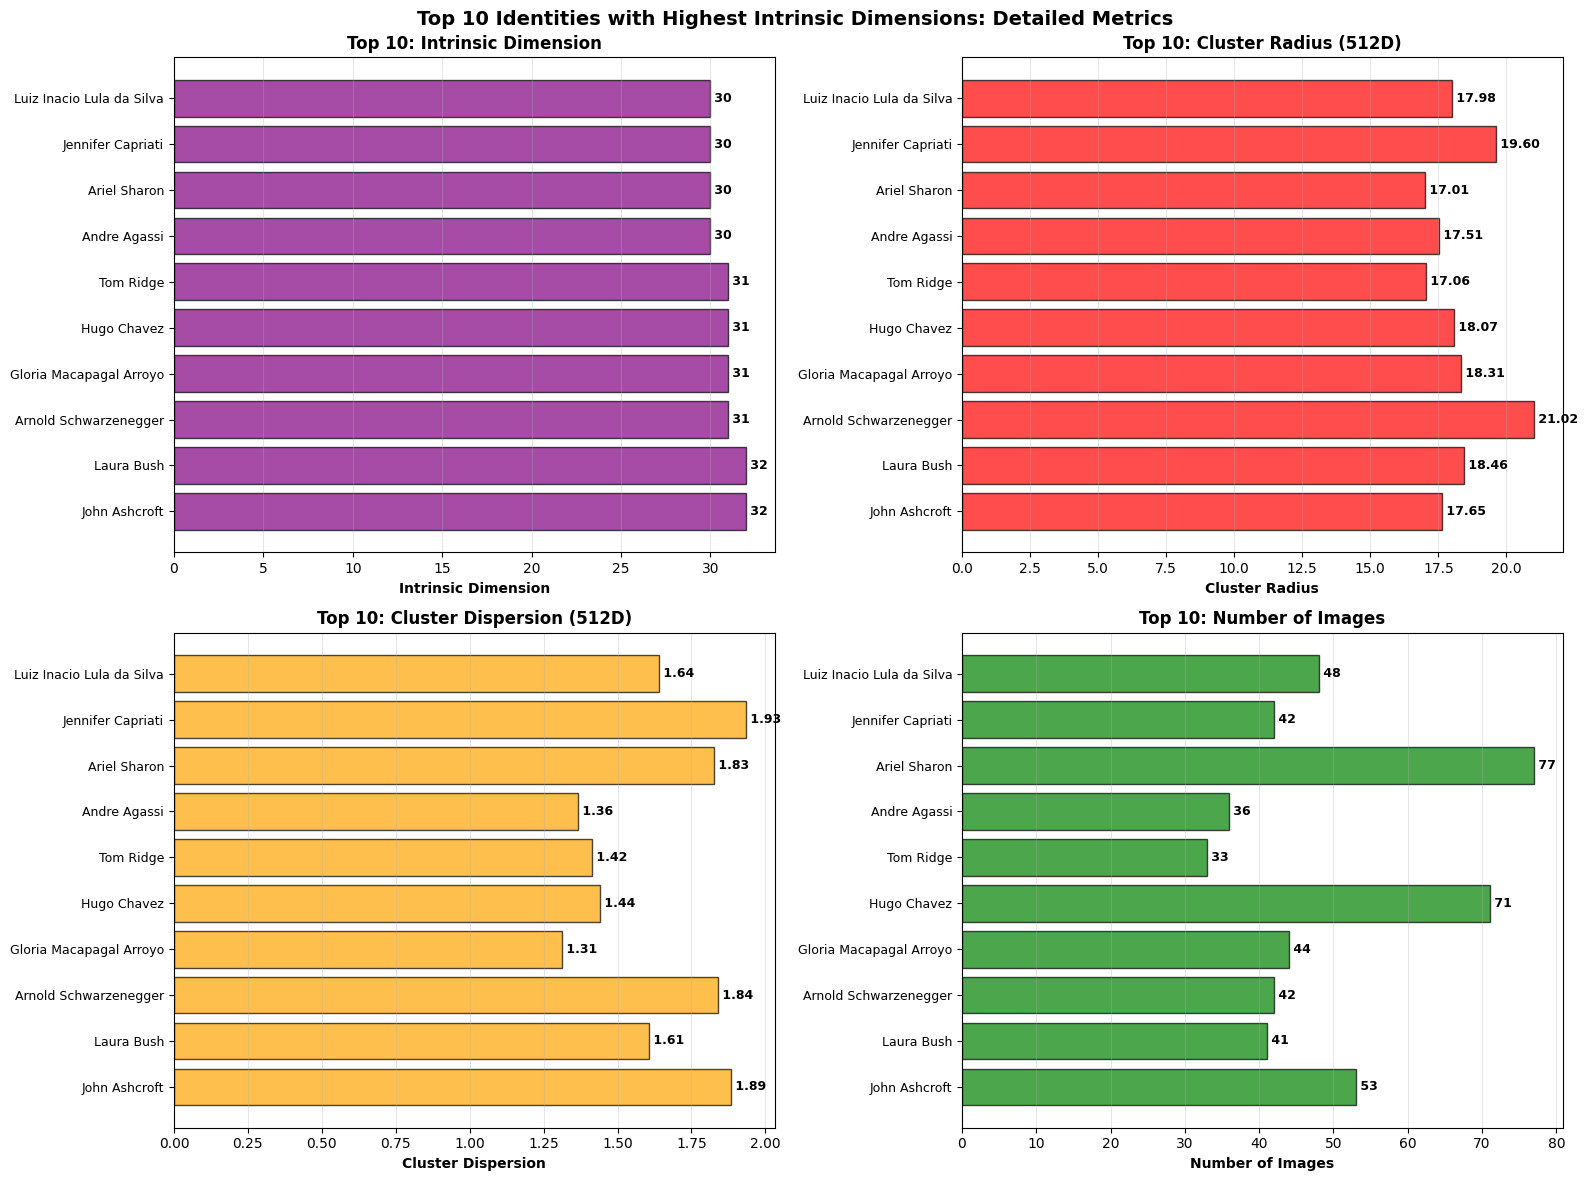

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#intrinsic Dimension
axes[0, 0].barh(range(len(top_10_data)), top_10_data['intrinsic_dimension'], color='purple', alpha=0.7, edgecolor='black')
axes[0, 0].set_yticks(range(len(top_10_data)))
axes[0, 0].set_yticklabels(top_10_data.index, fontsize=9)
axes[0, 0].set_xlabel('Intrinsic Dimension', fontweight='bold')
axes[0, 0].set_title('Top 10: Intrinsic Dimension', fontweight='bold', fontsize=12)
axes[0, 0].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(top_10_data['intrinsic_dimension']):
    axes[0, 0].text(val, i, f' {int(val)}', va='center', fontweight='bold', fontsize=9)

#radius
axes[0, 1].barh(range(len(top_10_data)), top_10_data['radius'], color='red', alpha=0.7, edgecolor='black')
axes[0, 1].set_yticks(range(len(top_10_data)))
axes[0, 1].set_yticklabels(top_10_data.index, fontsize=9)
axes[0, 1].set_xlabel('Cluster Radius', fontweight='bold')
axes[0, 1].set_title('Top 10: Cluster Radius (512D)', fontweight='bold', fontsize=12)
axes[0, 1].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(top_10_data['radius']):
    axes[0, 1].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#dispersion
axes[1, 0].barh(range(len(top_10_data)), top_10_data['dispersion'], color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_yticks(range(len(top_10_data)))
axes[1, 0].set_yticklabels(top_10_data.index, fontsize=9)
axes[1, 0].set_xlabel('Cluster Dispersion', fontweight='bold')
axes[1, 0].set_title('Top 10: Cluster Dispersion (512D)', fontweight='bold', fontsize=12)
axes[1, 0].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(top_10_data['dispersion']):
    axes[1, 0].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#number of Images
axes[1, 1].barh(range(len(top_10_data)), top_10_data['num_images'], color='green', alpha=0.7, edgecolor='black')
axes[1, 1].set_yticks(range(len(top_10_data)))
axes[1, 1].set_yticklabels(top_10_data.index, fontsize=9)
axes[1, 1].set_xlabel('Number of Images', fontweight='bold')
axes[1, 1].set_title('Top 10: Number of Images', fontweight='bold', fontsize=12)
axes[1, 1].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(top_10_data['num_images']):
    axes[1, 1].text(val, i, f' {int(val)}', va='center', fontweight='bold', fontsize=9)

plt.suptitle('Top 10 Identities with Highest Intrinsic Dimensions: Detailed Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

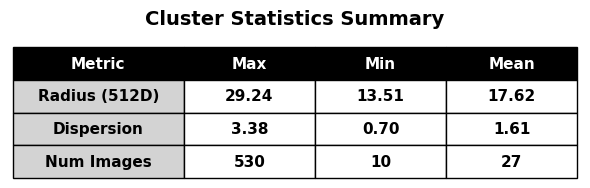

In [41]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('tight')
ax.axis('off')
summary_table_data = [
    ['Metric', 'Max', 'Min', 'Mean'],
    ['Radius (512D)', f"{merged_df['radius'].max():.2f}", f"{merged_df['radius'].min():.2f}", f"{merged_df['radius'].mean():.2f}"],
    ['Dispersion', f"{merged_df['dispersion'].max():.2f}", f"{merged_df['dispersion'].min():.2f}", f"{merged_df['dispersion'].mean():.2f}"],
    ['Num Images', f"{int(merged_df['num_images'].max())}", f"{int(merged_df['num_images'].min())}", f"{int(merged_df['num_images'].mean())}"]
]
table1 = ax.table(cellText=summary_table_data, cellLoc='center', loc='center', colWidths=[0.3, 0.23, 0.23, 0.23])
table1.auto_set_font_size(False)
table1.set_fontsize(11)
table1.scale(1, 2.5)
for i in range(4):
    table1[(0, i)].set_facecolor('black')
    table1[(0, i)].set_text_props(weight='bold', color='white')
for i in range(1, 4):
    table1[(i, 0)].set_facecolor('#D3D3D3')
    table1[(i, 0)].set_text_props(weight='bold')
    for j in range(1, 4):
        table1[(i, j)].set_facecolor('white')
        table1[(i, j)].set_text_props(weight='bold')
plt.title('Cluster Statistics Summary', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

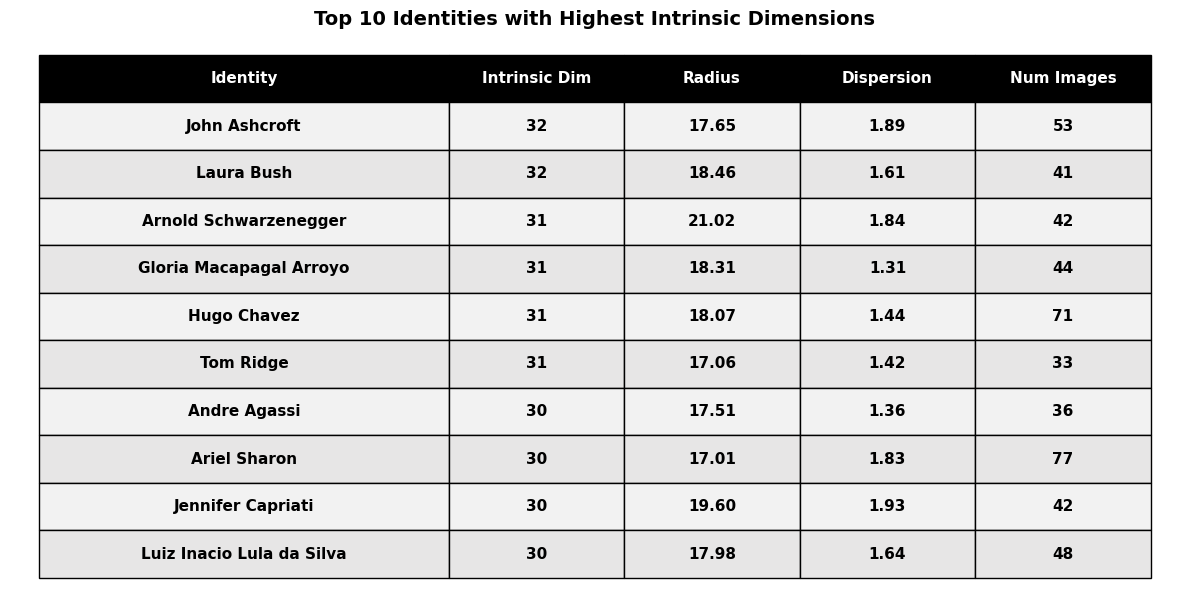

In [42]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')
table_data = [['Identity', 'Intrinsic Dim', 'Radius', 'Dispersion', 'Num Images']]
for identity, row in top_10_data.iterrows():
    table_data.append([
        identity,
        f"{int(row['intrinsic_dimension'])}",
        f"{row['radius']:.2f}",
        f"{row['dispersion']:.2f}",
        f"{int(row['num_images'])}"
    ])
table = ax.table(cellText=table_data, cellLoc='center', loc='center', colWidths=[0.35, 0.15, 0.15, 0.15, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

for i in range(5):
    table[(0, i)].set_facecolor('black')
    table[(0, i)].set_text_props(weight='bold', color='white')
for i in range(1, len(table_data)):
    for j in range(5):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')
        else:
            table[(i, j)].set_facecolor('#F2F2F2')
        table[(i, j)].set_text_props(weight='bold')
plt.title('Top 10 Identities with Highest Intrinsic Dimensions', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 12. Scatter Plot: Radius and Number of Images


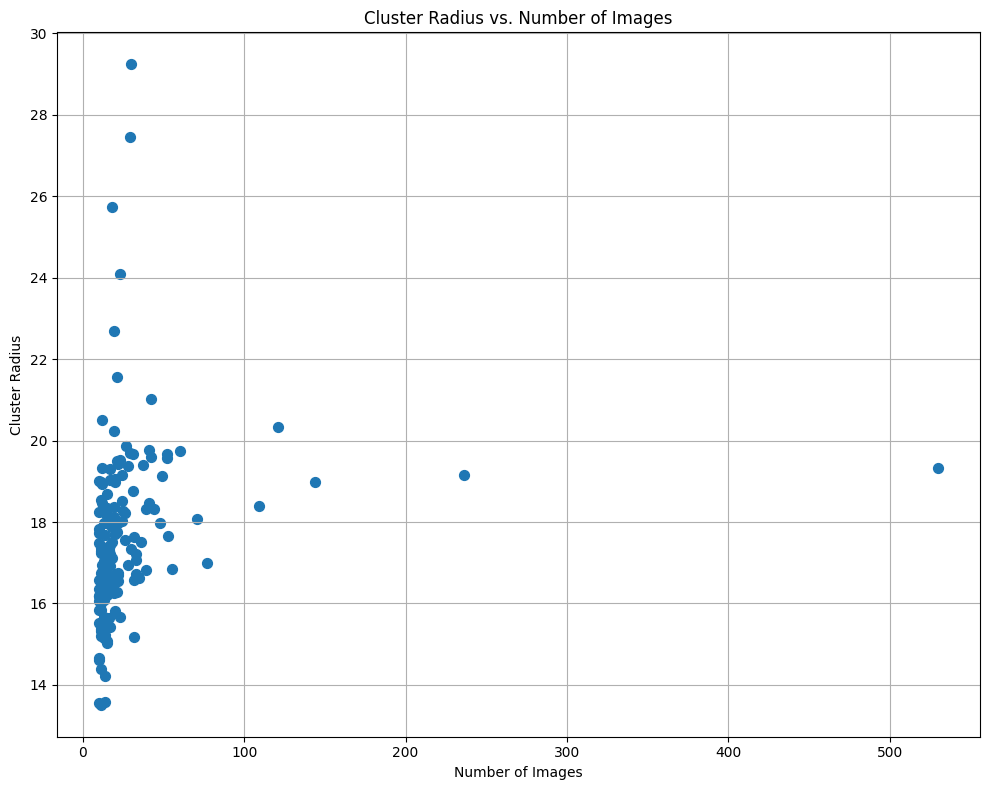

In [43]:
plt.figure(figsize=(10, 8))
plt.scatter(merged_df['num_images'], merged_df['radius'], s=50)
plt.title('Cluster Radius vs. Number of Images')
plt.xlabel('Number of Images')
plt.ylabel('Cluster Radius')
plt.grid(True)
plt.tight_layout()
plt.show()

No strong linear correlation between them


Even with few images some identites have very consistent embeddings, while others can be quite incosistent

